In [3]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import h5py
#from PIL import Image

import tensorflow as tf

In [4]:
print(tf.__version__)

2.0.0-alpha0


In [5]:
# Loading the data (cat/non-cat)
# train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

# Loading the data (cat/non-cat)
train_dataset = h5py.File('./train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

test_dataset = h5py.File('./test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

y = [1], it's a 'cat' picture.


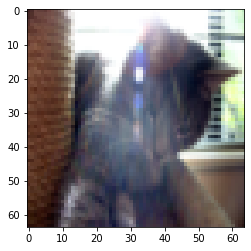

In [6]:
# Example of a picture
index = 42
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

#### Dataset descrption

In [7]:
#summary of original dataset
print('Number of training images {}'.format(train_set_x_orig.shape[0]))
print('Number of test images {}'.format(test_set_x_orig.shape[0]))
print('Training and test shape {}'.format(train_set_x_orig.shape))

Number of training images 209
Number of test images 50
Training and test shape (209, 64, 64, 3)


In [8]:
#set images sizes and channels
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
n_pix = train_set_x_orig.shape[1]
n_chan = train_set_x_orig.shape[3]
print('m_train {}, m_test {}, n_pix {}, n_chan {}'.format(m_train, m_test, n_pix, n_chan))

m_train 209, m_test 50, n_pix 64, n_chan 3


In [9]:
#normalize images and standardize labels
X_train = train_set_x_orig.copy() / 255.0
X_test = test_set_x_orig.copy() / 255.0

#flatten
# X_train = np.reshape(X_train, (m_train, -1))
# X_test = np.reshape(X_test, (m_test, -1))

# print(X_train.shape)

Y_train = train_set_y_orig.copy()
Y_test = test_set_y_orig.copy()

#### Test Rig Environment Setup

In [187]:
# set hyperparameters
batch_size = 32
epochs = 20
acc_limit = 0.95
learning_rate = 0.005

In [11]:
#class to stop at desired accuracy
class limitTraining(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') >=acc_limit):
            print('\nAccruacy Limit Reached. Training Stopped.')
            self.model.stop_training = True

In [13]:
def learning_optimizer(learning_rate):
    
    adam = tf.keras.optimizers.Adam(lr=learning_rate)

    return adam

### Single Neuron Example

In [188]:
def single_neuron(X_train, X_test, Y_train, Y_test, learning_rate, epochs):
    
    #initate input shape
    m_train = train_set_x_orig.shape[0]
    m_test = test_set_x_orig.shape[0]
    n_pix = train_set_x_orig.shape[1]
    n_chan = train_set_x_orig.shape[3]
    
    #initiate model
    model_single_nn = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_pix, n_pix, n_chan)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    #set optimizer and learning hyperparamters
    adam = learning_optimizer(learning_rate)
    
    #compile the model
    model_single_nn.compile(optimizer=adam,
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
    
    #print summary of model
    model_single_nn.summary()
    
    #instantiate callbacks class
    callbacks_s_nn = limitTraining()
    
    history = model_single_nn.fit(X_train, Y_train, epochs=epochs, callbacks=[callbacks_s_nn])
    
    evaluation = model_single_nn.evaluate(X_test, Y_test)
    
    predictions = model_single_nn.predict(X_test)
    
    #print out the accruacy from training
    print('Train accuracy: {}%'.format(history.history['accuracy'][-1]))
    
    #print our the accruacy from the test
    print('Test accuracy: {}%'.format(evaluation[1]))
    
    return history, evaluation, predictions
    
    

In [189]:
history, single_eval, single_predict = single_neuron(X_train, X_test, Y_train, Y_test, learning_rate, epochs)

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_52 (Flatten)         (None, 12288)             0         
_________________________________________________________________
dense_106 (Dense)            (None, 1)                 12289     
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
209/209 [==============================] - 0s 759us/sample - loss: 3.6339 - accuracy: 0.5837
Epoch 2/20
209/209 [==============================] - 0s 135us/sample - loss: 3.7341 - accuracy: 0.5311
Epoch 3/20
209/209 [==============================] - 0s 126us/sample - loss: 3.4308 - accuracy: 0.6220
Epoch 4/20
209/209 [==============================] - 0s 135us/sample - loss: 1.9372 - accuracy: 0.5742
Epoch 5/20
209/209 [==============================] - 0s 128us/sample - loss: 1.0832 - accuracy

Summary of single neuron hyperparameter tuning:

- With batch size 32:
    - Learning rate down to 0.001 did not converge in 20 epochs
    - Learning rate up to 0.1 did not converge.
    - Learning rate in range 0.01-0.05 best performance
- Dropping batch size to 16 and learning rate 0.05
   - Best observed test performance at 69.9%
- Batch size 32
    -learning rate 0.005 --> 91%/76%
   
Copy of best performing hyperparameters in the single neuron case:
- batch_size = 32
- epochs = 20
- acc_limit = 0.95
- learning_rate = 0.005

Performance: 91%/76%

### Multi-neuron Network

In [185]:
def multi_neuron(X_train, X_test, Y_train, Y_test, learning_rate, epochs):
    
    #initate input shape
    m_train = train_set_x_orig.shape[0]
    m_test = test_set_x_orig.shape[0]
    n_pix = train_set_x_orig.shape[1]
    n_chan = train_set_x_orig.shape[3]
    
    #initiate model
    model_multi_nn = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_pix, n_pix, n_chan)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    #set optimizer and learning hyperparamters
    adam = learning_optimizer(learning_rate)
    
    #compile the model
    model_multi_nn.compile(optimizer=adam,
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
    
    #print summary of model
    model_multi_nn.summary()
    
    #instantiate callbacks class
    callbacks_s_nn = limitTraining()
    
    history = model_multi_nn.fit(X_train, Y_train, epochs=epochs, callbacks=[callbacks_s_nn])
    
    evaluation = model_multi_nn.evaluate(X_test, Y_test)
    
    predictions = model_multi_nn.predict(X_test)
    
    #print out the accruacy from training
    print('Train accuracy: {}%'.format(history.history['accuracy'][-1]))
    
    #print our the accruacy from the test
    print('Test accuracy: {}%'.format(evaluation[1]))
    
    return history, evaluation, predictions
    
    

In [186]:
history, multi_eval, multi_predict = multi_neuron(X_train, X_test, Y_train, Y_test, learning_rate, epochs)

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_51 (Flatten)         (None, 12288)             0         
_________________________________________________________________
dense_104 (Dense)            (None, 128)               1572992   
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 129       
Total params: 1,573,121
Trainable params: 1,573,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
209/209 [==============================] - 0s 1ms/sample - loss: 19.6819 - accuracy: 0.5167
Epoch 2/20
209/209 [==============================] - 0s 374us/sample - loss: 5.3826 - accuracy: 0.5502
Epoch 3/20
209/209 [==============================] - 0s 397us/sample - loss: 3.6023 - accuracy: 0.5933
Epoch 4/20
209/209 [==============================] - 0s 394us

Summary of hyperparamter changes:

- With learning rate at 0.01
    - Batch size 16 --> 86%/43%
    - Changed batch size from 16 to 32 --> 81%/78%
- Increase learning rate to 0.05 --> local min overshoot
- Learning rate 0.005, batch size 32 --> 91%/68%
- Changed network architecture:
    - Add a Dense 16 layer before the output layer --> 80%/48%
- Added batch normalization with learning rate 0.0001 --> overfit in 9 epochs
- Architecture of 256 dense layer with batch 64 and learning rate 0.001 --> 78%/58%
- Best is dense 128 layer with batch 64, learning rate 0.005


### CNN implementation

Using the model with 128 > 1 dense layers above, add Conv2D and MaxPooling2D layers in front.

In [182]:
#define model
def cnn_model(X_train, X_test, Y_train, Y_test, learning_rate, epochs):
    
    #initate input shape
    m_train = train_set_x_orig.shape[0]
    m_test = test_set_x_orig.shape[0]
    n_pix = train_set_x_orig.shape[1]
    n_chan = train_set_x_orig.shape[3]
    
    #initiate model
    cnn_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(n_pix, n_pix, n_chan)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(input_shape=(n_pix, n_pix, n_chan)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    #set optimizer and learning hyperparamters
    adam = learning_optimizer(learning_rate)
    
    #compile the model
    cnn_model.compile(optimizer=adam,
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
    
    #print summary of model
    cnn_model.summary()
    
    #instantiate callbacks class
    callbacks_s_nn = limitTraining()
    
    history = cnn_model.fit(X_train, Y_train, epochs=epochs, callbacks=[callbacks_s_nn])
    
    evaluation = cnn_model.evaluate(X_test, Y_test)
    
    predictions = cnn_model.predict(X_test)
    
    #print out the accruacy from training
    print('Train accuracy: {}%'.format(history.history['accuracy'][-1]))
    
    #print our the accruacy from the test
    print('Test accuracy: {}%'.format(evaluation[1]))
    
    return history, evaluation, predictions
    

In [184]:
cnn_history, cnn_eval, cnn_pred = cnn_model(X_train, X_test, Y_train, Y_test, learning_rate, epochs) 

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 15376)             0         
_________________________________________________________________
dense_102 (Dense)            (None, 128)               1968256   
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 129       
Total params: 1,968,833
Trainable params: 1,968,833
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
209/209 [==============================] - 0s 2ms/sample - loss: 4.5185 - accuracy: 0.5550
Epoch 2

All tests done max 20 epochs and accuracy limit 98% on train sample. Note small sample.
- Inital performance with starting hyper parameters:
    - batch_size = 64
    - learning_rate = 0.005
    - performance 98%/78%
    

### Investigate mislabelled images

In [166]:
#force output predictions to 1 or 0 for cat or no cat.
def convert_outputs(predictions):
    return np.where(cnn_predictions > 0.5, 1, 0)

In [191]:
single_scores = convert_outputs(single_predict)
multi_scores = convert_outputs(multi_predict)
cnn_scores = convert_outputs(cnn_pred)
len(cnn_scores), len(Y_test)

(50, 50)

In [192]:
#compare results with Y_test and find incorrect labels
        
single_incorrect = [idx for idx, label in enumerate(single_scores) if label != Y_test[idx]]
multi_incorrect = [idx for idx, label in enumerate(multi_scores) if label != Y_test[idx]]
cnn_incorrect = [idx for idx, label in enumerate(cnn_scores) if label != Y_test[idx]]

len(single_incorrect),len(multi_incorrect), len(cnn_incorrect)

idx_wrong = [single_incorrect, multi_incorrect, cnn_incorrect]
print(idx_wrong)

[[18, 34, 35, 38, 39, 41, 44, 45], [18, 34, 35, 38, 39, 41, 44, 45], [18, 34, 35, 38, 39, 41, 44, 45]]


Note that the same example images are misclassified in each of the neural network structures.

Inspect the images.

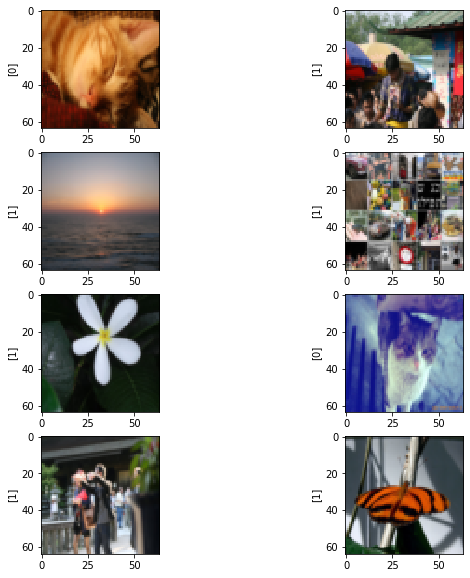

In [198]:
#display incorrrect labels
fig, axs = plt.subplots(int(len(poor_labels)/2), 2, figsize=(10,10))

for ax, index in zip(axs.flatten(), cnn_incorrect):
    ax.imshow(X_test[index])
    ax.set_ylabel(cnn_scores[index])